In [1]:
# # !pip install yfinance
# import sys
# !{sys.executable} -m pip install langchain langgraph dotenv
# !{sys.executable} -m pip install -U langchain-google-genai
# import sys
# !{sys.executable} -m pip install langchain-community
# !{sys.executable} -m pip install langchain_experimental

In [2]:
# from langchain.tools.python.tool import PythonREPLTool
from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt,Command
from langchain_experimental.tools import PythonREPLTool
import pandas, numpy
import yfinance as yf
import requests
from dotenv import load_dotenv
import os
load_dotenv()

import import_ipynb
import warnings
warnings.filterwarnings('ignore')

import import_ipynb
from web_search import web_search, get_recent_news, get_total_analysis
from get_stock_data import get_all_companies_basic_details, get_historical_prices_data, get_current_prices

In [3]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [4]:
class State(TypedDict):
    # messages : list
    messages : Annotated[list, add_messages]

In [5]:
@tool
def get_all_companies_basic_details_():
    """
    Returns a table of basic details of companies including Symbol, Security, Sector, Sub-Industry,
    Headquarters Location, Date Added, CIK, and Founded.

    This tool does not take any input and always returns the full dataset.
    """
    result = get_all_companies_basic_details()
    return result

@tool
def get_current_stock_price(symbol: str) -> str:
    '''
    Return the current stock price of the stock ticker symbol.
    :param symbol: stock ticker symbol
    :return: current price of the stock
    '''
    return get_current_prices([symbol])

@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''
    Buy stocks given the stock ticker symbol and quantity
    '''
    decision = interrupt(f'Approve buying {quantity} {symbol} stocks for {total_price:.2f}?')

    if decision == 'yes':
        return f'You bought {quantity} {symbol} stocks for {total_price}.'
    else:
        return f'Buying declined.'

@tool
def get_recent_news_about_stock(symbol: str):
    '''
    Retrieves recent news articles related to the stock ticker symbol from online sources like Google News.
    '''
    result = get_recent_news(symbol)
    return result

@tool
def search_web(query: str):
    '''
    Use this tool to retrieve current or unknown information from the internet.
    This is especially useful for answering anything not available in the model's training data. 
    '''
    result = web_search(query)
    return result

@tool
def get_historical_prices_data_of_stock(symbols: list[str], period: str, interval: str):
    """
    Fetches past or historical stock price data for a single ticker using Yahoo Finance.

    Args:
        symbols: A list of stock ticker symbols (e.g., ['AAPL', 'MSFT'])..
        period: Time span for historical data (e.g., '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max').
        interval: Data granularity (e.g., '1m', '5m', '15m', '1h', '1d', '1wk', '1mo', '3mo').

    Guidance:
        - If 'interval' is not specified, the LLM should pick an appropriate one based on 'period'.
        - For periods <= '1y', prefer '1wk'.
        - For > '1y', prefer '1mo'.
        - Aim for ~30–300 data points for readability.
        
    Returns:
        Historical price DataFrame as a string, or an error message if the inputs are invalid.
    """
    data = {}
    for symbol in symbols:
        data[symbol] = get_historical_prices_data(symbol, period, interval)
    return data

@tool
def get_total_analysis_stock(symbol: str, period : str, interval : str) -> str:
    """
    Generate an in-depth analysis and forecast of a stock.

    Includes:
        1. Sentiment analysis.
        2. Key news drivers.
        3. Short-term (1–4 weeks) and long-term (6+ months) outlooks.
        4. Buy/Hold/Sell recommendation.

    Args:
        symbol (str): Company name or stock ticker.
        period (str): Time period over which stock has to be analysed

    Returns:
        str: Comprehensive analysis report.
    """
    result = get_total_analysis(symbol,period, interval)
    return result
    
from langchain.tools import Tool
# from langchain_experimental.tools import PythonREPLTool

python_tool = Tool.from_function(
    func=PythonREPLTool()._run,
    name="python_repl",
    description="Use this tool to run Python code for math, stock indicators, data analysis, etc."
)

tools = [
    python_tool,
    get_all_companies_basic_details_,
    buy_stocks,
    get_current_stock_price,
    get_recent_news_about_stock,
    search_web,
    get_historical_prices_data_of_stock,
    get_total_analysis_stock
]

llm = init_chat_model('google_genai:gemini-2.0-flash')
llm_with_tools = llm.bind_tools(tools)

In [6]:
# def chatbot_node(state : State) -> State:
def chatbot_node(state : State):
    msg = llm_with_tools.invoke(state['messages'])
    return {'messages' : [msg]}

builder = StateGraph(State)

builder.add_node('chatbot',chatbot_node)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'chatbot')
builder.add_conditional_edges('chatbot',tools_condition)
builder.add_edge('tools','chatbot')
builder.add_edge('chatbot',END)

graph = builder.compile(checkpointer=memory)

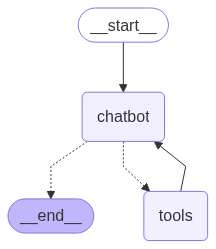

In [7]:
from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
config = {'configurable': {'thread_id': 'buy_thread'}}

state = None
while True:
    in_message = input('You :')
    print('You :',in_message)
    if in_message.lower() in {'quit', 'exit'}:
        break

    if state is None:
        # First message, initialize message list
        messages = [
        {"role": "system", "content": "You have access to a Python code tool. Use it for any math, stock indicator, or data analysis tasks."},
        {"role": "user", "content": in_message}
        ]

    else:
        # Continue the conversation 
        messages = state['messages'] + [{'role': 'user', 'content': in_message}]
        
    state = graph.invoke({'messages': messages}, config=config)
    print("Bot :", state['messages'][-1].content)
    print('\n\n')


You : Deeply analyse Microsoft stock of past 5 year and prepare detailed report from it


You : Deeply analyse Microsoft stock of past 5 year and prepare detailed report from it


[*********************100%***********************]  1 of 1 completed


Bot : Here is a detailed analysis of Microsoft (MSFT) stock based on the past 5 years:

**Overall Performance:**

*   **Trend:** The stock has generally increased over the past 5 years.
*   **Volatility:** Medium. There have been significant price swings, but not extreme daily volatility.
*   **Returns:** The stock has had a total return of 137.74%, with an average monthly return of approximately 2.33%.
*   **Volume Insights:** Trading volume has been inconsistent, with spikes during price corrections.

**Technical Indicators:**

*   **RSI (14-day approximation):** Likely Overbought (based on recent price increases).
*   **MACD (approximation):** Bullish.
*   **SMA (50-day approximation):** Indicates a continuation of the upward trend.

**News Sentiment:**

*   Positive, driven by institutional investment and analyst price target increases.

**Key News Drivers:**

*   **Institutional Investment:** Firms purchasing MSFT shares suggests confidence in the stock’s future performance.
*   *

You : What stocks are current talk of the town?


You : What stocks are current talk of the town?
Bot : Based on the search results, here are some of the stocks that are currently trending:

*   **Top Gainers:** Jyong Biotech Ltd, Bel Fuse, Gentex Corp, Accelerant Holdings
*   **Most Active:** Intel Corp, Opendoor Technologies, Tesla, NVIDIA Corp, Lucid Group, Warner Bros Discovery, Denison Mines Corp
*   **Other Stocks Mentioned:** Palantir Technologies, Amazon, Semrush Holdings, Roku

Please note that "trending" can mean different things (e.g., most discussed, biggest price increase, etc.). The stocks listed above are appearing frequently in financial news and market summaries.





You : What are the risks involved in investing in Tesla?


You : What are the risks involved in investing in Tesla?
Bot : Investing in Tesla (TSLA) involves several risks that potential investors should consider:

**Company-Specific Risks:**

*   **Valuation:** TSLA stock trades at high valuation multiples, which may not be supported by growth, profitability, or innovation compared to peers.
*   **Production and Operational Issues:** Tesla's future success depends on ramping up manufacturing capacity and infrastructure. Operational setbacks in new products like the Cybertruck and Robotaxi could negatively impact the stock.
*   **Competition:** Tesla faces increasing competition from both legacy automakers and other EV manufacturers.
*   **Cost and Affordability:** Tesla cars can be expensive for consumers to purchase, and costly for Tesla to make.
*   **Key Person Risk:** Tesla is heavily reliant on its CEO, Elon Musk.
*   **Carbon Credit Revenue:** Shifting political winds and market dynamics could hurt Tesla's profits, especially its revenue

You : What are revenue and net income of Apple for past 5 years?


You : What are revenue and net income of Apple for past 5 years?
Bot : Here are Apple's revenue and net income for the past 5 fiscal years (ending in September):

| Year | Revenue (billions USD) | Net Income (billions USD) |
|---|---|---|
| 2020 | 274.5 | 57.41 |
| 2021 | 365.8 | 94.68 |
| 2022 | 394.1 | 99.803 |
| 2023 | 383.2 | 96.995 |
| 2024 | 391.0 | 93.736 |





You : get me Tesla stock prices of past 5 years


You : get me Tesla stock prices of past 5 years


[*********************100%***********************]  1 of 1 completed


Bot : Here are the monthly closing prices for Tesla (TSLA) stock over the past 5 years (August 2020 - July 2025):

| Date       | Close Price |
|------------|-------------|
| 2020-08-01 | 166.106674  |
| 2020-09-01 | 143.003326  |
| 2020-10-01 | 129.346664  |
| 2020-11-01 | 189.199997  |
| 2020-12-01 | 235.223328  |
| 2021-01-01 | 264.510010  |
| 2021-02-01 | 225.166672  |
| 2021-03-01 | 222.643326  |
| 2021-04-01 | 236.479996  |
| 2021-05-01 | 208.406662  |
| 2021-06-01 | 226.566666  |
| 2021-07-01 | 229.066666  |
| 2021-08-01 | 245.240005  |
| 2021-09-01 | 258.493347  |
| 2021-10-01 | 371.333344  |
| 2021-11-01 | 381.586670  |
| 2021-12-01 | 352.260010  |
| 2022-01-01 | 312.239990  |
| 2022-02-01 | 290.143341  |
| 2022-03-01 | 359.200012  |
| 2022-04-01 | 290.253326  |
| 2022-05-01 | 252.753326  |
| 2022-06-01 | 224.473328  |
| 2022-07-01 | 297.149994  |
| 2022-08-01 | 275.609985  |
| 2022-09-01 | 265.250000  |
| 2022-10-01 | 227.539993  |
| 2022-11-01 | 194.699997  |
| 2022-12-01 | 

You : What are latest news about Blackrock


You : What are latest news about Blackrock
Bot : Here's a summary of the latest news regarding BlackRock (BLK):

*   **Insider Activity:** A Senior Managing Director sold 2,407 shares of BlackRock. Also, Representative Jefferson Shreve (R-Indiana) recently sold shares of BlackRock (NYSE:BLK).
*   **M&A:** BlackRock's stock is climbing despite threats to its $22.8 billion Panama Ports deal.
*   **Executive Changes:** A BlackRock veteran joined SharpLink Gaming as Co-CEO.
*   **Dividends:** BlackRock declared a quarterly dividend of $5.21 on common stock.
*   **Security Measures in China:** BlackRock is implementing new security measures for employees traveling to China, including restrictions on using company devices.
*   **Q2 Performance:** BlackRock's stock reached new highs following a record-breaking Q2.





You : Compare the returns of Apple vs Tesla over the last 5 years.


You : Compare the returns of Apple vs Tesla over the last 5 years.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Bot : Okay, let's compare the returns of Apple (AAPL) and Tesla (TSLA) over the past 5 years. I'll calculate the total return based on the closing prices from August 1, 2020, to July 1, 2025.

**Apple (AAPL):**

*   Initial Price (August 1, 2020): 125.435806
*   Final Price (July 1, 2025): 213.880005
*   Total Return: ((213.880005 - 125.435806) / 125.435806) \* 100 = 70.51%

**Tesla (TSLA):**

*   Initial Price (August 1, 2020): 166.106674
*   Final Price (July 1, 2025): 316.059998
*   Total Return: ((316.059998 - 166.106674) / 166.106674) \* 100 = 90.28%

**Summary:**

| Stock | Total Return (5 Years) |
|---|---|
| Apple (AAPL) | 70.51% |
| Tesla (TSLA) | 90.28% |

**Conclusion:**

Over the past 5 years, Tesla (TSLA) has provided a higher return (90.28%) compared to Apple (AAPL) (70.51%).





You : exit


You : exit


In [9]:
# state['messages'][-4].content